## Part 4: Fraud Detection using Graph Neural Networks


##### Curated By - Paritosh Sinha

#### Importing the necessary library

In [1]:
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
from time import time

# import pytorch and set dgl backend to pytorch
import os
os.environ['DGLBACKEND'] = 'pytorch'

import torch.nn  as nn
import torch.nn.functional as F

try:
    import dgl
except ModuleNotFoundError:
    !pip install dgl
    import dgl

import networkx as nx
import matplotlib.pyplot as plt


#!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU:{torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU is available, using CPU")

No GPU is available, using CPU


### Import the Dataset and familiarise with the features

In [3]:
#Reading the test dataset 
transactions_df = pd.read_csv('./IEEE_Fraud_Detection/train_transaction.csv')

#Checking for the structure of the input file 
num_transactions = transactions_df.shape[0]
print("Number of transactions: ", num_transactions)

#Checking for the % of Fradulent transactions
# Calculate the proportion of fraudulent transactions
fraudulent_proportion = transactions_df['isFraud'].value_counts(normalize=True).get(1, 0)
print(f"Proportion of fraudulent transactions in the entire dataset: {fraudulent_proportion:.3f}")


#Reading the label csv of the dataset
identity_df = pd.read_csv('./IEEE_Fraud_Detection/train_identity.csv')
print("Number of transaction with ID data: ",identity_df.shape[0])

display(transactions_df.head())
display(identity_df.head())

Number of transactions:  590540
Proportion of fraudulent transactions in the entire dataset: 0.035
Number of transaction with ID data:  144233


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
transactions_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,...,1.103011,1.659811,1.239916,0.942599,2.313863,1.433424,0.328917,0.089034,0.298829,0.171655,0.045507,0.052002,0.251761,0.283140,0.264208,1.000007,139.748713,408.682375,230.413180,10.995986,118.195658,4.202175,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,...,0.768897,16.252538,3.775050,20.588816,39.526468,25.962948,3.264745,0.628352,3.175062,1.724218,0.289573,0.318310,0.481889,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10

In [6]:
transactions_df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

In [7]:
identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [8]:
identity_df.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,0.000000,100.000000,49.000000,-360.000000,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,0.000000,100.000000,64.000000,720.000000,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [9]:
identity_df.dtypes

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


### Train Test Split

In [10]:
# Setting the Train Test ratio for the dataset
train_val = 0.8

# determine number of training records
n_train = int(transactions_df.shape[0]*train_val)

# train/val split
train_ids = transactions_df.TransactionID[:n_train]
val_ids = transactions_df.TransactionID[n_train:]

In [11]:
# Iterating through each feature and print unique values and their counts
for feature in transactions_df.columns:
    unique_values = transactions_df[feature].unique()
    num_unique_values = len(unique_values)
    print(f"Feature: {feature}, Number of unique values: {num_unique_values}")
    print(unique_values)
    print()


Feature: TransactionID, Number of unique values: 590540
[2987000 2987001 2987002 ... 3577537 3577538 3577539]

Feature: isFraud, Number of unique values: 2
[0 1]

Feature: TransactionDT, Number of unique values: 573349
[   86400    86401    86469 ... 15811079 15811088 15811131]

Feature: TransactionAmt, Number of unique values: 20902
[  68.5    29.     59.   ...  557.54 1659.95  400.78]

Feature: ProductCD, Number of unique values: 5
['W' 'H' 'C' 'S' 'R']

Feature: card1, Number of unique values: 13553
[13926  2755  4663 ... 13166  8767 18038]

Feature: card2, Number of unique values: 501
[ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134

Feature: C11, Number of unique values: 1476
[2.000e+00 1.000e+00 5.000e+00 ... 1.197e+03 1.206e+03 1.210e+03]

Feature: C12, Number of unique values: 1199
[  0.   2.   1. ... 276. 155. 274.]

Feature: C13, Number of unique values: 1597
[  1.  25.  12. ... 912. 899. 840.]

Feature: C14, Number of unique values: 1108
[  1.   2.   3. ... 792. 793. 794.]

Feature: D1, Number of unique values: 642
[ 14.   0. 112.  61.   1.  72.  46.  62. 485.  66. 169.  29. 121. 245.
 201. 478. 542. 181.  91.   3. 108. 394.  21.   5.  36.  12. 104. 464.
 238. 239.  47. 456. 216.  78.  31. 404.  57.   9.  40. 429. 119.  41.
 250.  56. 416.  37. 369. 157. 164.  10.  59. 248. 453. 457. 125. 217.
   8.  32. 146. 358.  60. 154. 151.  94.  30.  93.  11. 483.  83.  86.
 163. 234. 343.  51. 102. 480. 318. 463. 172. 379. 153. 142. 339. 322.
 127. 303.  48.  64.  22.  79. 257. 213.   6.  27. 107. 265. 117. 462.
 139.  90. 174.  19. 223. 333. 411. 451. 128.  77. 140. 420.   4.  89.
  50. 298.  17. 290. 129.  15. 150. 

Feature: D12, Number of unique values: 636
[ nan   0.  35. 163. 398.  24. 338.  18. 242.  42. 318. 348.   1.  28.
 289. 346.  60.   2.  75. 260. 227. 237.  83. 470.  71. 123. 235. 282.
 233.  49.  26. 372. 210.   3. 240. 320. 103. 122.  23. 182. 366. 315.
 275. 354. 377.  39. 302. 298.   9. 175.   5. 455.  12.   7.  50. 479.
 -83.  88. 345.  13. 214.  21. 299.  82.  41. 363.  55.  14.  27. 215.
   4. 169. 209. 471. 358.  30. 229. 332. 261. 284. 379. 292. 183. 265.
 263. 161. 349.  11. 191. 296. 293.  61. 201. 357. 277. 295. 294. 323.
 335. 107.  78. 413.  10.  96. 203. 108. 388. 362. 189. 244. 351. 321.
  95. 316. 369. 360. 222. 281. 457. 113. 106. 383. 101.  77. 339. 100.
 150. 220.  65. 160. 301. 243. 238. 326. 158. 176. 276. 407. 328. 121.
  15. 218.  46. 104. 151. 115. 355. 111. 384. 147. 370.  48. 142.  47.
 343. 378.  66. 264. 271.  68. 224. 231. 317. 361. 374. 375.  44. 387.
  92.  58. 325. 444.  17. 373. 274. 380. 285. 386.  31. 352. 199. 118.
  80. 180. 410.  63. 485. 257. 341

Feature: M7, Number of unique values: 3
[nan 'F' 'T']

Feature: M8, Number of unique values: 3
[nan 'F' 'T']

Feature: M9, Number of unique values: 3
[nan 'F' 'T']

Feature: V1, Number of unique values: 3
[ 1. nan  0.]

Feature: V2, Number of unique values: 10
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  8.]

Feature: V3, Number of unique values: 11
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  8.  9.]

Feature: V4, Number of unique values: 8
[ 1. nan  2.  0.  3.  4.  5.  6.]

Feature: V5, Number of unique values: 8
[ 1. nan  2.  0.  3.  4.  5.  6.]

Feature: V6, Number of unique values: 11
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  9.  8.]

Feature: V7, Number of unique values: 11
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  9.  8.]

Feature: V8, Number of unique values: 10
[ 1. nan  2.  3.  0.  6.  4.  5.  8.  7.]

Feature: V9, Number of unique values: 10
[ 1. nan  2.  3.  0.  4.  6.  5.  8.  7.]

Feature: V10, Number of unique values: 6
[ 0. nan  1.  2.  3.  4.]

Feature: V11, Number of unique values: 7
[ 0. 

Feature: V127, Number of unique values: 24415
[ 117.            0.         1758.         ...  481.79000854   91.47000122
 1771.2800293 ]

Feature: V128, Number of unique values: 14508
[   0.          925.          102.5        ...  125.6651001    91.47000122
 1771.2800293 ]

Feature: V129, Number of unique values: 1969
[   0.          209.94999695   29.         ... 2422.83007812  799.90002441
  919.        ]

Feature: V130, Number of unique values: 12333
[  0.         354.          60.         ... 351.6499939  379.95001221
 481.79000854]

Feature: V131, Number of unique values: 4445
[   0.          135.           34.         ...  184.5         969.95001221
 1105.        ]

Feature: V132, Number of unique values: 6561
[  0.          50.         200.         ... 115.24320221 153.65759277
 125.6651001 ]

Feature: V133, Number of unique values: 9950
[ 117.           0.        1404.        ...  680.5       1908.
  125.6651001]

Feature: V134, Number of unique values: 8179
[   0.         790

Feature: V150, Number of unique values: 1997
[  nan 1803. 1804. ...   22.   23.   24.]

Feature: V151, Number of unique values: 57
[nan 49.  1.  4. 50. 51.  2. 52. 53. 54. 48. 47. 46. 45. 44. 43. 42.  3.
 55. 56. 57. 41. 40. 39. 38. 37. 36. 35. 33. 34. 30. 31. 29. 28. 27. 26.
 25.  5.  6. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 13. 14. 12. 11.  9.
 10.  8.  7.]

Feature: V152, Number of unique values: 40
[nan 64.  1.  4.  2.  7.  8.  3. 65. 66. 67. 68.  5.  6. 69. 63. 62. 61.
 60. 59. 57. 55. 54. 53. 51. 52. 50. 49. 56. 58.  9. 10. 11. 12. 13. 14.
 15. 16. 17. 18.]

Feature: V153, Number of unique values: 20
[nan  0.  1.  6.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18.]

Feature: V154, Number of unique values: 20
[nan  0.  1.  7.  2.  8.  3.  4.  5.  6.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18.]

Feature: V155, Number of unique values: 26
[nan  0.  1.  2.  7.  3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]

Feature: V156, Number 

Feature: V168, Number of unique values: 966
[ nan   0.   3.   1.   4.   2.   5.   7.   8.  10.   6.  47.  38.  48.
  41.   9.  11.  12.  13.  14.  15.  16.  17.  49.  50.  53.  44.  39.
  40.  18.  19.  20.  21.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  22.  33.  34.  35.  36.  37.  42.  43.  45.  46.  23.  51.  52.  54.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  55.  56.  57.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  89.  93.
  94.  95.  97.  98.  99. 100. 101. 103. 104. 105. 106. 107. 108. 111.
 112. 113. 114. 115. 116. 117. 118. 120. 121. 122. 123. 124. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 138. 139. 140. 141. 142.
 143. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164.  67. 165.  68.  69.  70. 167. 168.
  71. 166.  72. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.
 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 20

Feature: V187, Number of unique values: 216
[ nan   1.   2.   4.   3.  85.  28.  31.  30.   5.  84.  29.   6.  82.
  83.   7.  32.  33.   8.   9.  34.  10.  36.  80.  11.  12.  81.  13.
  14.  37.  38.  39.  40.  41.  15.  43.  76.  44.  75.  46.  47.  48.
  35.  50.  51.  52.  73.  74.  53.  55.  56.  57.  58.  77.  78.  79.
  59.  60.  61.  63.  64.  65.  66.  67.  86.  68.  69.  70.  71.  72.
  87.  88.  89.  90.  91.  92.  93.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 108. 109. 111. 112. 113. 114. 115.  42. 116.
 117. 118. 119. 121. 122. 123. 124. 125. 126. 127. 128. 129. 131. 132.
 133. 134. 135. 136. 137. 138.  94. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 155. 154.  16. 107. 156. 157.
 158. 110. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 120. 187. 188. 189. 190. 191. 192. 195. 196. 197. 198. 199. 200.
 203. 205. 130. 206. 207. 208. 20

Feature: V229, Number of unique values: 92
[ nan   1.   4.   5.   2.   6.   3. 140.   9. 141. 142. 143.   8. 144.
   7. 145. 146.  10. 147. 148.  38. 127. 128.  11.  12.  13.  14.  39.
  40. 149. 150. 151.  15.  45. 152. 153. 154.  16. 156. 157.  21. 158.
 160. 161. 162. 163. 164.  37. 165. 166. 167. 169. 170. 171. 172. 173.
 174. 175. 176.  41.  20.  23.  22.  34.  17.  18.  19.  24.  25.  27.
  28.  26.  29.  30.  31.  32.  33.  35.  36.  42.  43.  44.  46.  47.
  48.  49.  50.  51.  52.  53.  54.   0.]

Feature: V230, Number of unique values: 67
[nan  1.  4.  5.  6.  2.  3. 59. 60. 61. 62.  8. 63.  9. 10. 64. 65.  7.
 35. 36. 11. 12. 13. 14. 46. 44. 45. 47. 48. 15. 16. 49. 50. 52. 53. 54.
 55. 56. 57. 58. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 37. 38. 39. 40. 41. 42. 43. 51.  0.]

Feature: V231, Number of unique values: 295
[ nan   0.   1.   2.   3.   4.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.   5.   6.  17.  18.  19.  20.  21.  22.  23. 

Feature: V251, Number of unique values: 20
[nan  1.  0.  2.  7.  8.  3.  4.  6.  5. 11. 10. 13. 16. 12. 17.  9. 14.
 15. 18.]

Feature: V252, Number of unique values: 26
[nan  1.  7.  4.  2.  8.  9. 10. 11. 12. 13.  3.  5.  6. 14. 15. 16. 17.
 18.  0. 19. 20. 21. 22. 23. 24.]

Feature: V253, Number of unique values: 67
[ nan   1.   2. 131.   4.   3.   5. 132. 133. 134.   8. 135.   7. 136.
 137.   9. 138. 139.   6.  61.  62.  10. 140. 141. 142.  32. 143. 144.
 146. 147.  18. 148. 149. 150. 151. 152. 153. 154. 155. 157. 158. 159.
 160. 161. 162. 163.  30.  14.  16.  11.  20.  21.  12.  13.  15.  31.
  17.  19.  25.  35.  43.   0.  22.  29.  28.  23.  24.]

Feature: V254, Number of unique values: 46
[nan  1.  2. 54.  4.  3. 55. 56. 57.  8.  5.  6. 58.  9. 59. 60. 26. 27.
 45. 43. 44. 46. 47. 11. 48. 49. 50. 51. 52. 53.  7. 10. 12. 13. 14. 15.
 16. 17. 18.  0. 19. 20. 21. 22. 23. 24.]

Feature: V255, Number of unique values: 47
[nan  1.  0.  2.  7.  3.  4. 12.  5.  6. 19.  9. 40. 23. 43.  

Feature: V288, Number of unique values: 12
[ 0.  2.  1.  3.  4.  5.  6.  7.  8. nan  9. 10.]

Feature: V289, Number of unique values: 14
[ 0.  2.  1.  4.  3.  7.  5.  6.  8.  9. nan 10. 11. 12.]

Feature: V290, Number of unique values: 59
[ 1.  4.  2.  3.  5.  6. 33. 31.  7.  8.  9. 16. 18. 19. 27. 29. nan 34.
 21. 22. 28. 42. 41. 37. 48. 57. 52. 10. 26. 11. 12. 13. 14. 32. 50. 61.
 64. 66. 54. 51. 17. 20. 15. 56. 60. 25. 23. 24. 30. 39. 36. 38. 65. 67.
 40. 47. 35. 45. 44.]

Feature: V291, Number of unique values: 220
[1.000e+00 4.000e+00 2.000e+00 3.000e+00 5.000e+00 6.000e+00 7.000e+00
 8.000e+00 9.000e+00 1.000e+01 8.730e+02 8.740e+02 1.100e+01 1.200e+01
 1.300e+01 1.400e+01 8.620e+02 8.540e+02 8.530e+02 2.200e+01 1.500e+01
 1.600e+01 1.700e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 1.800e+01
 3.300e+01 2.800e+01 2.300e+01 1.900e+01 2.000e+01 2.900e+01 8.250e+02
 3.000e+01 8.270e+02       nan 3.100e+01 8.480e+02 7.860e+02 7.870e+02
 7.890e+02 7.900e+02 7.950e+02 7.960e+02 8.030e+0

Feature: V311, Number of unique values: 3099
[  0.          31.84129906  29.         ...  29.61219978 167.
  48.84479904]

Feature: V312, Number of unique values: 8069
[   0.          135.           90.32790375 ...  366.76000977 1105.
   48.84479904]

Feature: V313, Number of unique values: 5530
[  0.          90.32790375  29.         ...  48.84479904 612.
 481.79000854]

Feature: V314, Number of unique values: 11378
[  0.         495.          90.32790375 ...  48.84479904 481.79000854
 188.86999512]

Feature: V315, Number of unique values: 6974
[  0.          90.32790375  29.         ...  48.84479904 612.
 481.79000854]

Feature: V316, Number of unique values: 9815
[  0.          50.         200.         ... 585.11999512 643.63201904
 488.76599121]

Feature: V317, Number of unique values: 15185
[ 117.            0.         1404.         ...  585.11999512  643.63201904
  488.76599121]

Feature: V318, Number of unique values: 12310
[  0.         790.          68.5        ... 585.1199951

Feature: V332, Number of unique values: 2454
[   nan     0.   145. ...  9500. 25600. 29200.]

Feature: V333, Number of unique values: 1972
[   nan     0.    25. ... 11600. 16000. 19600.]

Feature: V334, Number of unique values: 144
[        nan 0.00000e+00 3.50000e+01 6.00000e+00 5.00000e+01 3.00000e+01
 1.50000e+02 5.00000e+00 7.00000e+00 1.00000e+02 1.00000e+01 2.50000e+01
 2.00000e+01 1.25000e+02 5.50000e+01 1.50000e+01 4.00000e+01 8.00000e+00
 7.00000e+01 7.50000e+01 5.00000e+02 6.00000e+01 2.00000e+02 4.00000e+02
 2.50000e+02 9.50000e+01 6.50000e+01 1.55000e+02 2.70000e+01 9.00000e+01
 1.00000e+03 4.50000e+01 3.00000e+02 1.10000e+02 8.00000e+01 8.50000e+01
 9.00000e+02 6.50000e+02 1.30000e+01 3.50000e+02 2.75000e+02 1.80000e+01
 9.75000e+02 2.25000e+02 6.00000e+02 1.75000e+02 2.00000e+03 3.00000e+03
 3.25000e+02 7.50000e+00 7.50000e+02 1.25000e+03 3.30000e+01 1.40000e+03
 4.50000e+02 8.50000e+02 7.00000e+02 9.25000e+02 1.65000e+02 2.50000e+03
 3.10000e+03 3.75000e+02 4.25000e+02 1

### Data Preprocessing

In [12]:
#getting transaction related id columns from transactions_df 
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain'] 

# getting categorical(binary or ordinal) columns for features
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']   

# get features and labels as this will not be used as an input to the neural net
not_transactional_features = ['isFraud','TransactionDT'] + id_cols
features_cols = [col for col in transactions_df.columns if col not in not_transactional_features]

In [13]:
#Creating df for transaction node features making dummy variables for the features
#Filling missing dummy variables with 0

features_df = pd.get_dummies(transactions_df[features_cols], columns=cat_cols).fillna(0)

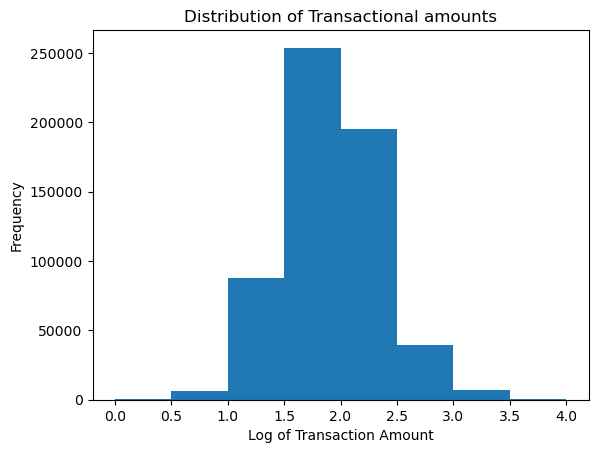

In [14]:
# Scaling and Normalisation of transaction amount by taking take log of the Transaction Amount
features_df['TransactionAmt'] = features_df['TransactionAmt'].apply(np.log10)

#Distribution of Amount values
features_df['TransactionAmt'].plot(kind='hist', bins=[0,0.5,1,1.5,2,2.5,3,3.5,4])
plt.title('Distribution of Transactional amounts')
plt.xlabel('Log of Transaction Amount')
plt.show()

In [15]:
# Creating a dataframe which will contain the Trandsaction id and label of the transaction
labels_df = transactions_df[['TransactionID','isFraud']]

#Create a list of all node types except TransactionID This will help in creating the graph
node_types = id_cols + list(identity_df.columns)

#TransactionID will not be of use for the graph vizualisation or for the training of the neural nets
node_types.remove('TransactionID')

#Combining the Dataframes using merge dfs to get a table with all ID data
full_identity_df = identity_df.merge(transactions_df[id_cols+['TransactionID']], on='TransactionID', how='right')

# create a dictionary of df that will determine the edges in the graph
edge_dfs = {}
for ntype  in node_types:
    edge_dfs[ntype] = full_identity_df[['TransactionID', ntype]].dropna() 

In [16]:
# initialize the dictionary to store each ID to dgl node index dictionary
id_to_node = {}

# Create a mapping for 'target' nodes using 'TransactionID'
id_to_node['target'] = dict([(v,k) for k,v in dict(transactions_df['TransactionID']).items()])

# Iterate through other node types and create mappings for them
for ntype in node_types:
    new_nodes_ids = edge_dfs[ntype][ntype].unique()
    new_nodes_dgl = np.arange(len(new_nodes_ids)+1)
    id_to_node[ntype] = { a:b for a,b in zip(new_nodes_ids, new_nodes_dgl)}

In [17]:
#Checking the id_to_node dictionary
id_to_node['card4']


{'discover': 0, 'mastercard': 1, 'visa': 2, 'american express': 3}

In [18]:
# instantiate the edge list dictionary
edgelists = {} # Will strore the edge list for different edge types
num_nodes_dict = {} #No of nodes for each node type

#This loop iterates over each node type (e.g., 'Card', 'Email', etc.) specified in the node_types list.
#Nodetypes is the features of the dataset except for the transaction_id
for ntype in node_types:
    # Edge types in DGL are represented as tuples (source node type, edge type, destination node type).
    edge_type = ('target','target<>'+ntype,ntype)
    rev_edge_type = (ntype, ntype+'<>target','target')
    
    # get list of initial nodes and destination nodes using id_to_node mapping.
    source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
    destination_nodes = edge_dfs[ntype][ntype].apply(lambda a : id_to_node[ntype][a]).to_numpy()
    
    # add to dict the source -> destination and the reverses of it 
    edgelists[edge_type] = (source_nodes, destination_nodes )
    edgelists[rev_edge_type] = (destination_nodes, source_nodes)
    
    # get number of unique destination nodes
    num_nodes_dict[ntype] = len(np.unique(destination_nodes))
    
# add self-loops for target nodes
source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
edgelists[('target','target<>target','target')] = (source_nodes,source_nodes)
num_nodes_dict['target'] = num_transactions

In [19]:
# create the graph
g = dgl.heterograph(edgelists, num_nodes_dict)

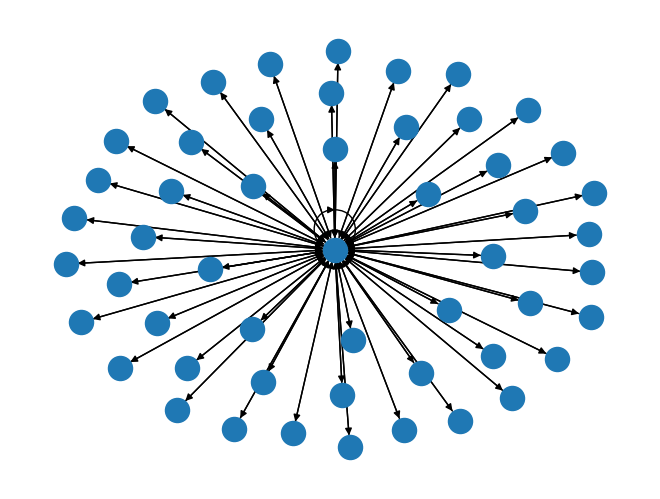

In [20]:
# Visualizing the metagraph (sanity check: it should be star-shaped, with the target node in the center and a node for each id feature)
meta = g.metagraph()
nx.draw(meta)

### 1. Data pre-processing

In [21]:
features_df.head()

,TransactionID,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,...,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,M1_F,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000,1.835691,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0
1,2987001,1.462398,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,2987002,1.770852,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0
3,2987003,1.698970,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
4,2987004,1.698970,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# create pytorch tensor consisting of features for each node
feature_tensor = torch.from_numpy(features_df.drop('TransactionID', axis=1).to_numpy())

# add feature data to graph
g.nodes['target'].data['features'] = feature_tensor

In [23]:
#Check
#Random target node, compare expected features with the feature of the node
trial = 1515

# Expected feature
orig_feat = torch.from_numpy(features_df.iloc[trial,1:].to_numpy())

# Feature from the node of the graph
graph_feat = g.ndata['features']['target'][trial]

assert max(orig_feat - graph_feat) == 0 #Differences between the vectors 
print('Feature vectors match from dataset and graph')

Feature vectors match from dataset and graph


In [24]:
#Splitting data into train and validate
train_mask = [ id_to_node['target'][x] for x in train_ids]
val_mask = [ id_to_node['target'][x] for x in val_ids]

In [25]:
#Creating tensor can then be used to train and evaluate the model.
labels = torch.tensor(labels_df['isFraud'].to_numpy()).float()

In [26]:
#Store mean of all feature dimension based on the node features of the 'target' node type
mean = torch.mean(g.ndata['features']['target'], axis=0)

#Store standard deviation of all feature dimension based on the node features of the 'target' node type
std = torch.sqrt(torch.sum((g.ndata['features']['target'] - mean)**2, axis=0)/g.ndata['features']['target'].shape[0])

In [27]:
#Ensure that each feature has a mean of 0 and a standard deviation of 1
#Standardization
g.ndata['features']['target'] = (g.ndata['features']['target'] - mean)/std

### Modelling 

### 2. Model architecture

### Architecture 1

In [28]:
#Defining the layers, no.of neurons, epochs etc
# Convolution layers
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8
CONV_LAYERS = 2 
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

In [29]:
#Flow of data in layers with activation function
from dgl.nn.pytorch import HeteroGraphConv, HeteroEmbedding, GraphConv
from torch.nn import Linear

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

#Defining the Feed Forward Neural net  for preprocessing and postprocessing the target label
class feedfwd_block(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers):
        super().__init__()
        self.input_layer = Linear(in_dim, hidden_dim)
        self.hidden_layer = Linear(hidden_dim, hidden_dim)
        self.output_layer = Linear(hidden_dim, out_dim)
        self.n_layers = n_layers
        
##Activation function : ReLU 
    def forward(self, in_feats):
        h = self.input_layer(in_feats)
        h = nn.ReLU()(h)
        for i in range(1, self.n_layers):
            h = self.hidden_layer(h)
            h = nn.ReLU()(h)
        h = self.output_layer(h)        
        return h
            

#Defining the Model class
class RGCN(nn.Module):
    def __init__(self, target_feature_dim, in_dim, hidden_dim, conv_out_dim, num_conv_layers, num_embeddings, target_pre_h_dim, target_pre_layers, target_post_h_dim, target_post_layers):
        super().__init__()
        #Creating dictionary for HeteroGraphConv
        entry_module_dict = { etype : GraphConv(in_feats=in_dim, out_feats=hidden_dim) for etype in g.etypes}

        hidden_model_dict = { etype : GraphConv(in_feats=hidden_dim, out_feats=hidden_dim) for etype in g.etypes}

        final_model_dict1 = { etype : GraphConv(in_feats=hidden_dim, out_feats=conv_out_dim) for src,etype,dst in g.canonical_etypes if dst == 'target'}
        final_model_dict2 = { etype : GraphConv(in_feats=hidden_dim, out_feats=1) for src,etype,dst in g.canonical_etypes if dst != 'target'}
        final_model_dict = {**final_model_dict1, **final_model_dict2}
        
        self.num_conv_layers = num_conv_layers
        
        self.embed_layer = HeteroEmbedding(
            num_embeddings,
            in_dim
        )
        ##Preprocessing block for target features--layers for message passing and aggregation over the graph.
        self.target_preprocessing = feedfwd_block(
            target_feature_dim, 
            target_pre_h_dim, 
            in_dim, 
            target_pre_layers)
        self.conv1 = HeteroGraphConv(
            entry_module_dict,
            aggregate = 'sum'
        )
        self.conv2 = HeteroGraphConv(
                hidden_model_dict,
                aggregate = 'sum'
        )

        self.conv3 = HeteroGraphConv(
            final_model_dict,
            aggregate = 'sum'
        )
        self.target_postprocessing = feedfwd_block(
            conv_out_dim, 
            target_post_h_dim, 
            1, 
            target_post_layers
        )
#defining the forward pass of the model, 
#incorporating the embedding, preprocessing, convolutional layers, and postprocessing        
    def forward(self, graph, input_features):
        embeds = self.embed_layer({ ntype : graph.nodes(ntype) for ntype in node_types }) #Embedding 
        input_features = input_features.to(dtype=torch.float32) #Input
        target_features = self.target_preprocessing(input_features) #Target
        embeds['target'] = target_features 
        h = self.conv1(graph, embeds)
        h = {k: F.relu(v) for k, v in h.items()}
        for i in range(2, self.num_conv_layers):
            h = self.conv2(graph, h)
            h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv3(graph, h)
        h['target'] = self.target_postprocessing(h['target'])
        
        return h

In [30]:
# Defining the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

In [31]:
#Weight vector for loss multiplier will help dealing with the class imbalance in both train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

In [32]:
#Function will take care of one training epoch for the model
def train_one_epoch(epoch_no, model, g, features, labels, train_mask, val_mask, threshold, return_probs=False):
    t0 = time()
    # Forward pass - Logits are converted to probabilities using a sigmoid activation function
    logits_dict = model(g, features)
    logits = logits_dict['target']
    del logits_dict
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
       
    labels = labels.reshape_as(preds)
    
    #Calculating the training and validation losses
    loss = loss_fn(probs[train_mask], labels[train_mask])
    with torch.no_grad():
        val_loss = val_loss_fn(probs[val_mask], labels[val_mask])
    
    #Calculating the accuracies
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    
    #backprop after each epoch optimizer's gradient is zeroed.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#Return the following values post the epoch    
    if return_probs:
        return loss, val_loss, train_acc, val_acc, time()-t0, probs, preds
    else:
        return loss, val_loss, train_acc, val_acc, time()-t0

In [33]:
#visualise loss history
def loss_history_plot(loss_history, val_loss_history=None, small=False):
    if small:
        size = (5,2)
    else:
        size = (7,4)
    fig, ax =plt.subplots(1,1,figsize=size)
    ax.plot(loss_history, label='Train')
    if val_loss_history:
        ax.plot(val_loss_history, label='Val')
        ax.legend()
    plt.show()

In [34]:
#Final model
def train(model, g, num_epochs, labels, train_mask, val_mask, threshold):
    best_val_acc = 0
    epoch_times = []
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    
    features = g.nodes['target'].ndata['features']
    
    for epoch in range(num_epochs):
        
        if epoch < num_epochs-1:
            loss, val_loss, train_acc, val_acc, epoch_time = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold)
        else:
            loss, val_loss, train_acc, val_acc, epoch_time, final_probs, final_preds = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold, return_probs=True)
            
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['loss'].append(loss.detach().numpy())
        epoch_times.append(epoch_time)
        
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            
        if epoch % 10 == 10-1:
            loss_rate_of_change = (history['loss'][-1]-history['loss'][-5])/5
            print(f"Epoch {epoch+1} loss: {loss:.3f}, (rate of change: {loss_rate_of_change:.4f}), val accuracy: {val_acc:.3f} (best: {best_val_acc:.3f})\n\
            -- Average time per epoch: {np.mean(epoch_times):.1f}sec (last 5: {np.mean(epoch_times[-5:]):.1f}sec).\
            Estimated time to end: {(num_epochs-epoch-1)*np.mean(epoch_times[-5:])/60:.0f} mins")
            
        if epoch % 25 == 25-1:
            loss_history_plot(history['loss'][-25:], history['val_loss'][-25:], small=True)
            loss_history_plot(history['val_acc'][-25:], small=True)
            
    print('-'*60)
    print(f"Training complete. \
    Final loss: {loss:.3f}, \
    final val accuracy: {val_acc:.3f}, (best: {best_val_acc:.3f}).")
    
    return final_probs, final_preds, history

Epoch 10 loss: 0.932, (rate of change: -0.0024), val accuracy: 0.865 (best: 0.867)
            -- Average time per epoch: 11.2sec (last 5: 10.9sec).            Estimated time to end: 4 mins
Epoch 20 loss: 0.914, (rate of change: -0.0017), val accuracy: 0.867 (best: 0.867)
            -- Average time per epoch: 11.2sec (last 5: 11.1sec).            Estimated time to end: 2 mins


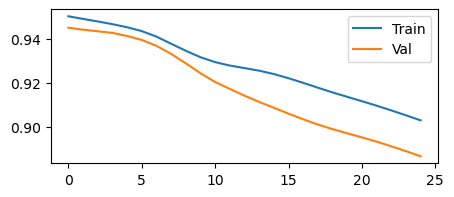

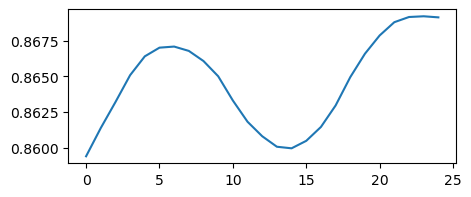

Epoch 30 loss: 0.891, (rate of change: -0.0019), val accuracy: 0.870 (best: 0.870)
            -- Average time per epoch: 11.2sec (last 5: 11.0sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 0.891,     final val accuracy: 0.870, (best: 0.870).


In [46]:
QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

In [36]:
print (g.ndata)

defaultdict(<class 'dict'>, {'features': {'target': tensor([[  1.8357,  19.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  1.4624,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  1.7709, 287.0000,   0.0000,  ...,   0.0000,   1.0000,   0.0000],
        ...,
        [  1.4907,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  2.0682,   3.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  2.4471,   0.0000,   0.0000,  ...,   0.0000,   1.0000,   0.0000]],
       dtype=torch.float64)}})


In [43]:
print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

Training set: mean of probabilities, predictions, and true labels:
tensor(0.4406, grad_fn=<MeanBackward0>)
tensor(0.1452)
tensor(0.0351)

Validation set:
tensor(0.4477, grad_fn=<MeanBackward0>)
tensor(0.1406)
tensor(0.0344)


In [44]:
print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 14.06 %.
[[99383  2123]
 [14661  1941]]
False positive rate: 88.3 %.
False negative rate: 2.09 %.
True negative rate: 11.69 % (specificity).
True positive rate: 97.91 % (sensitivity).


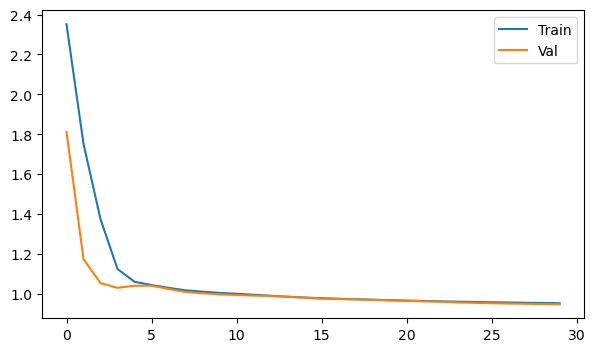

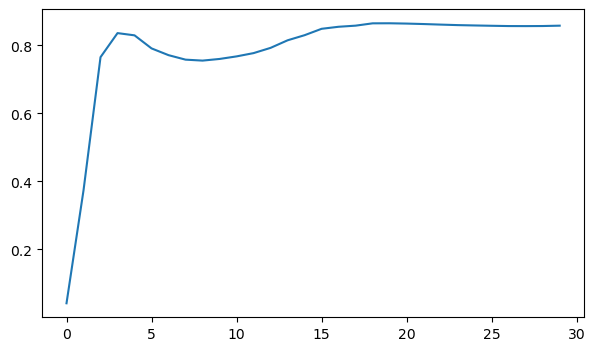

In [45]:
loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### 5. Visualization of learned embedding

## Visualization of learned embeddings

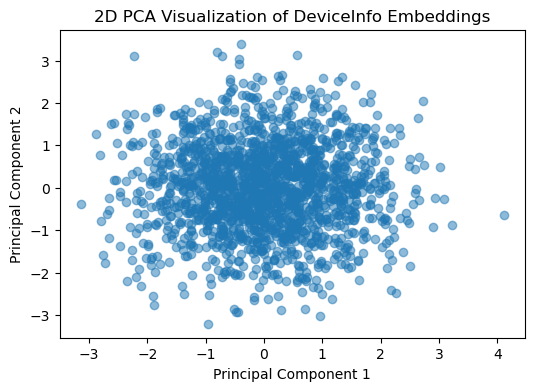

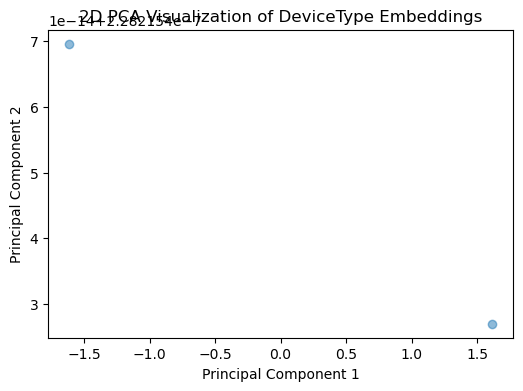

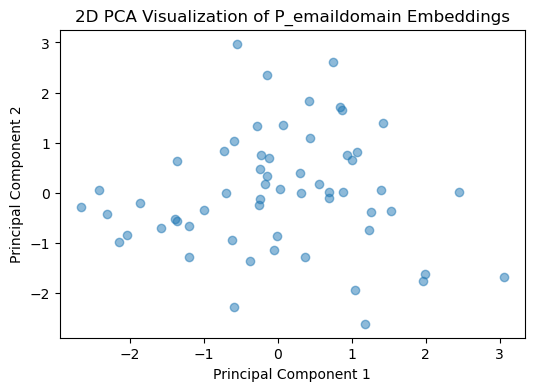

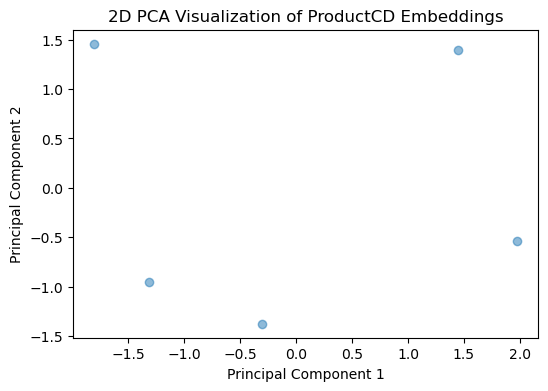

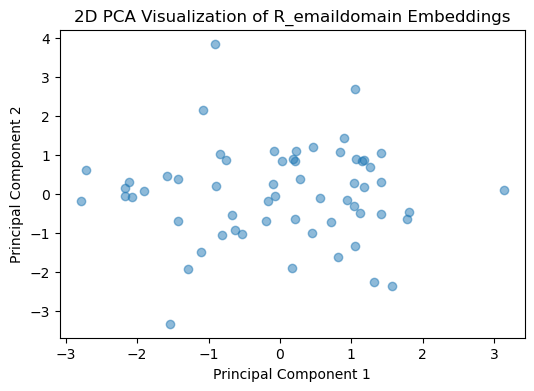

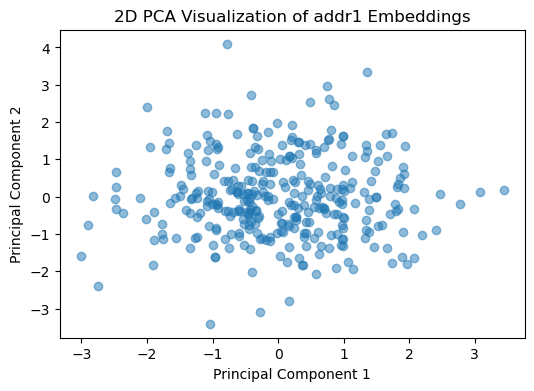

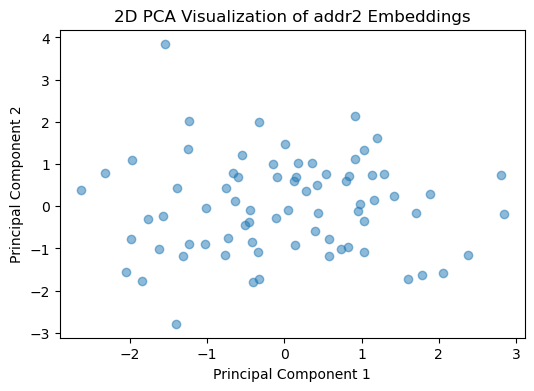

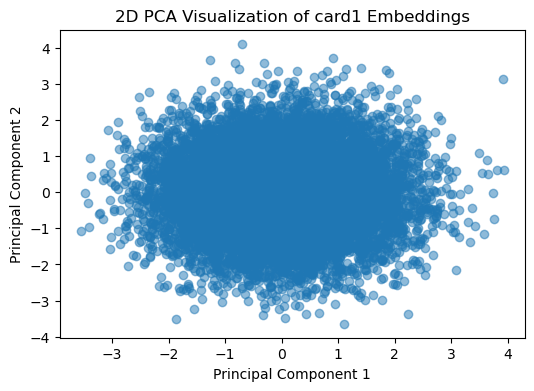

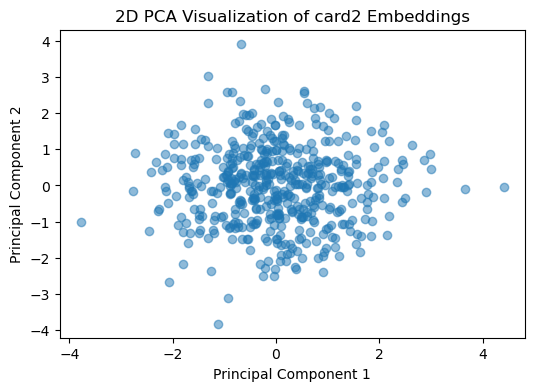

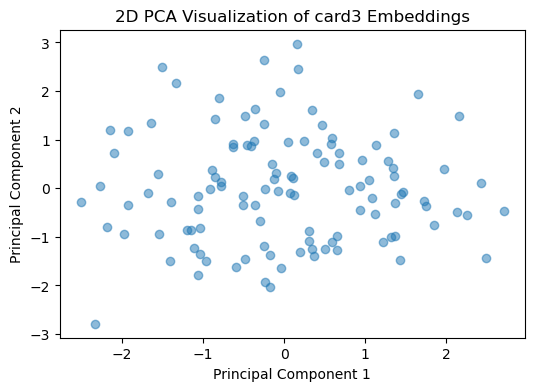

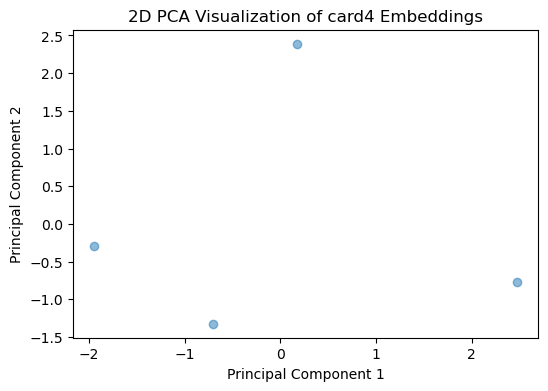

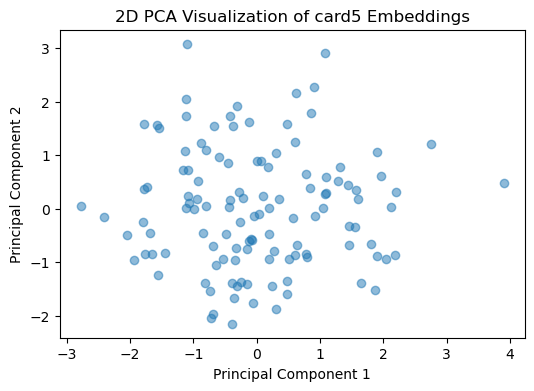

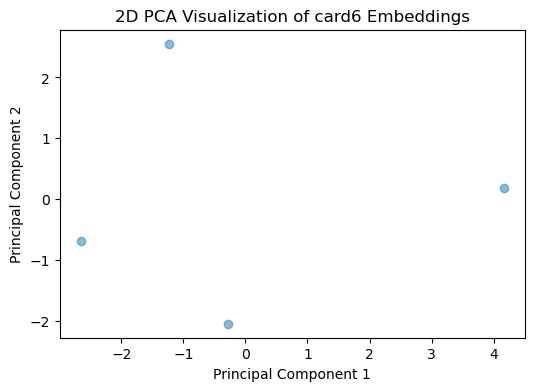

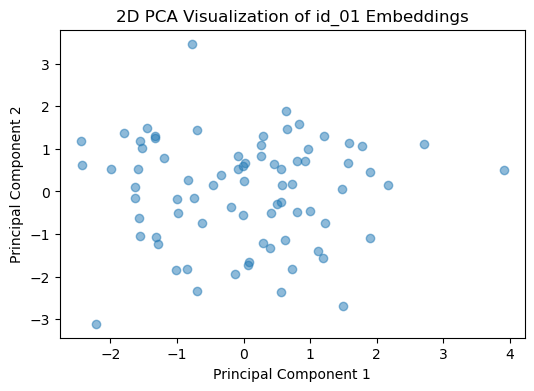

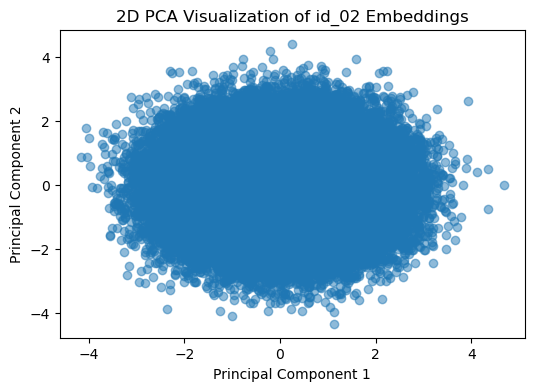

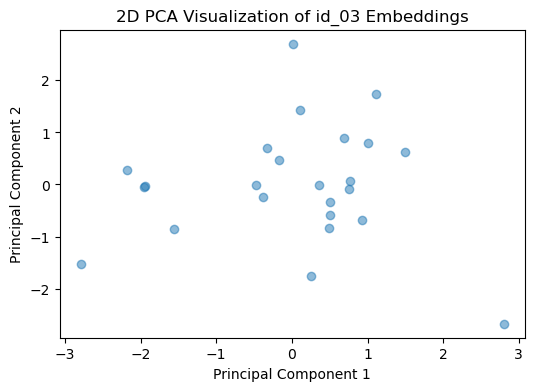

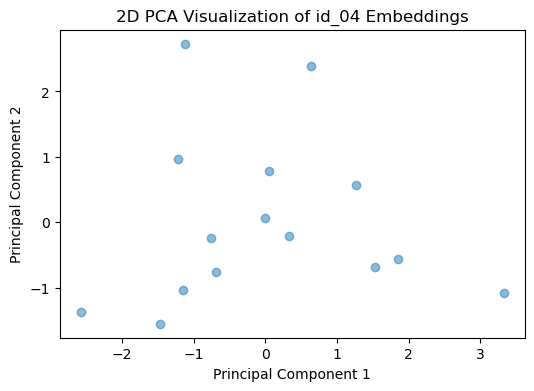

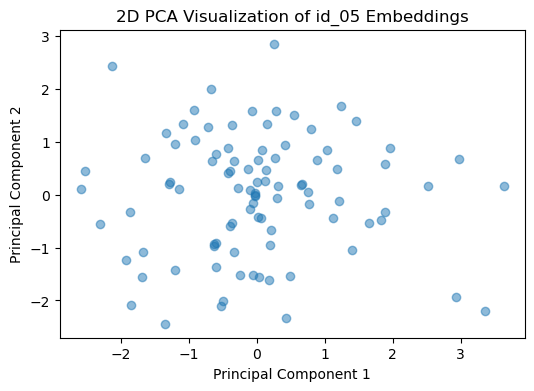

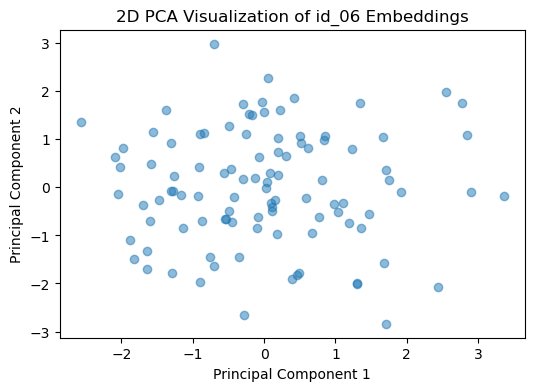

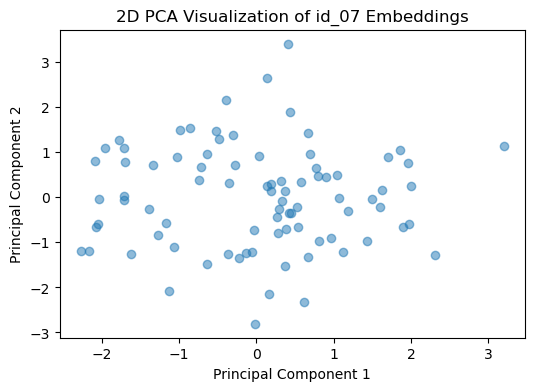

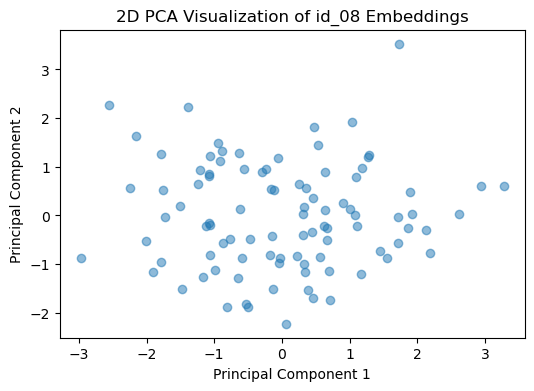

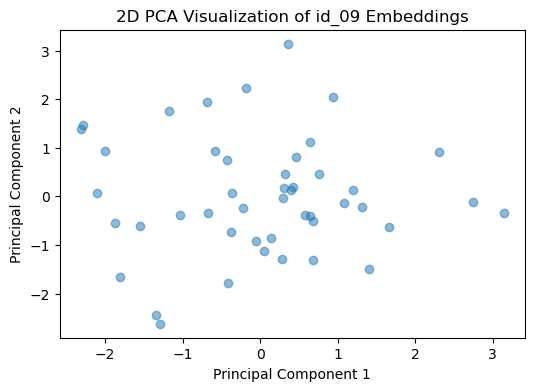

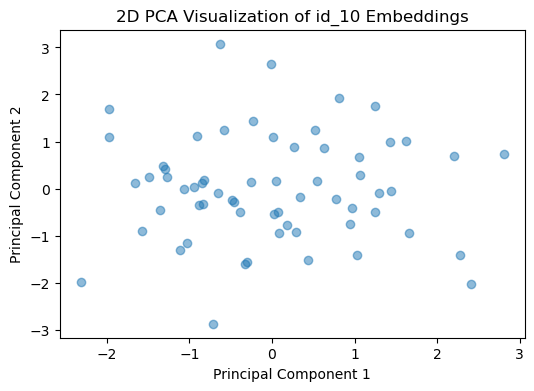

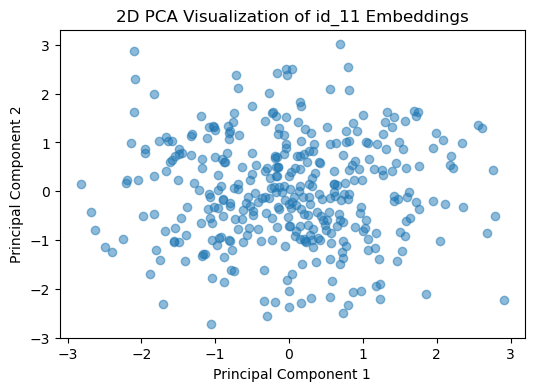

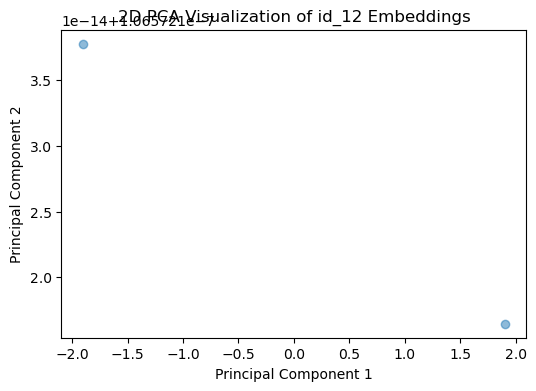

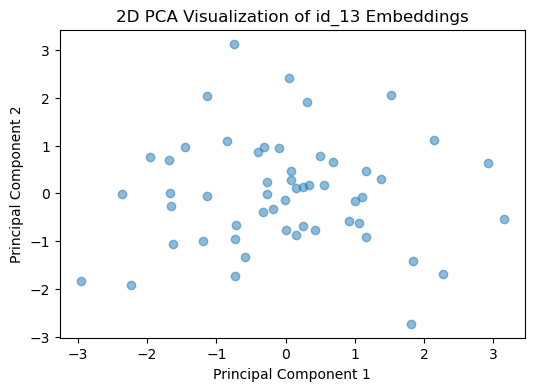

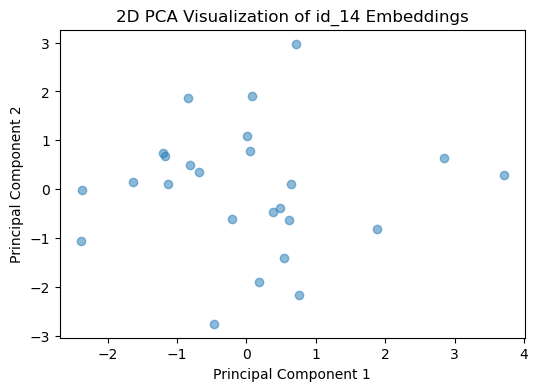

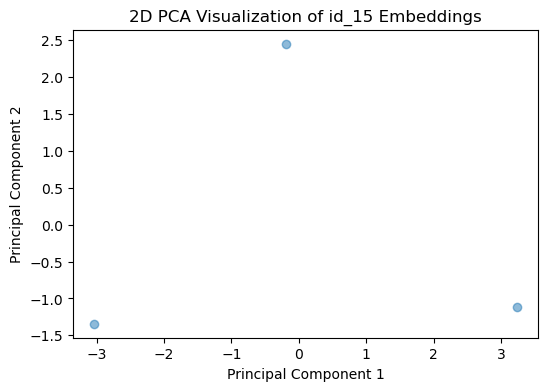

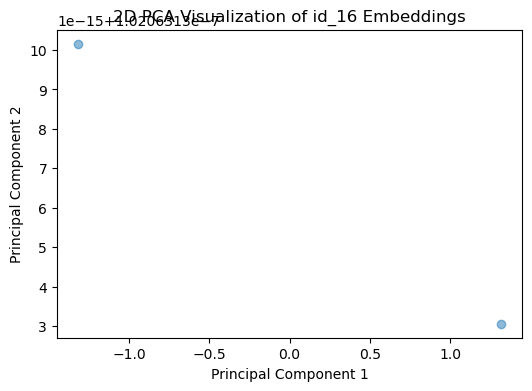

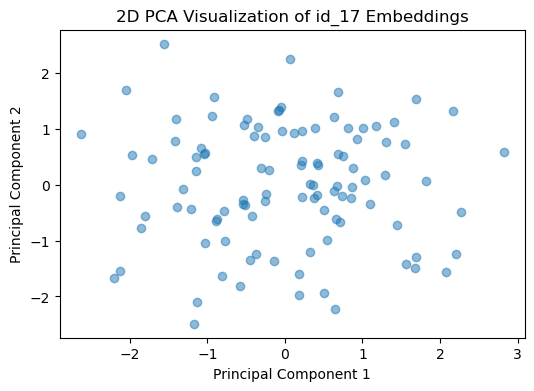

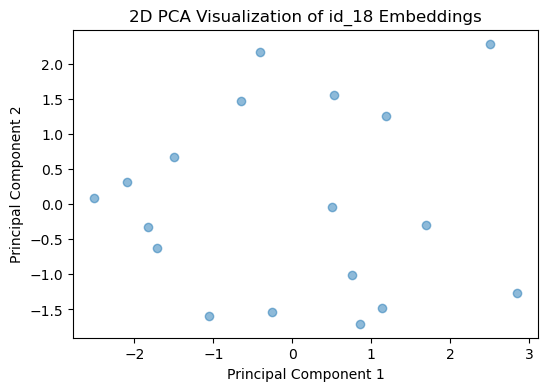

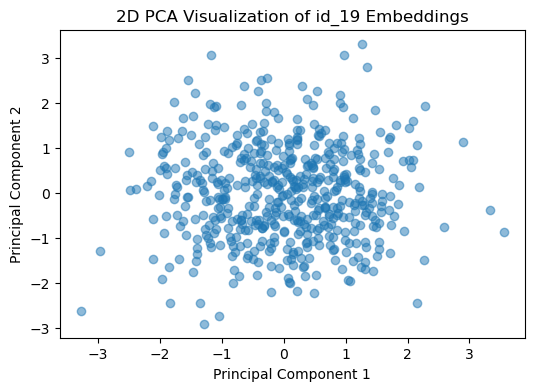

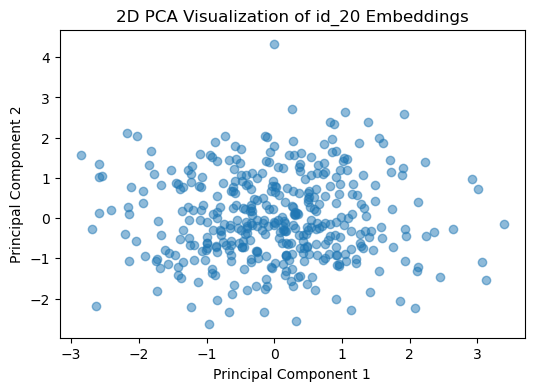

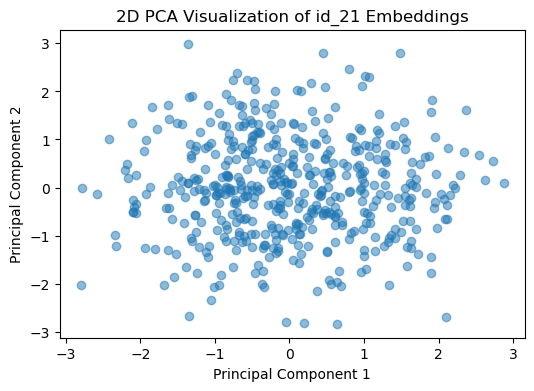

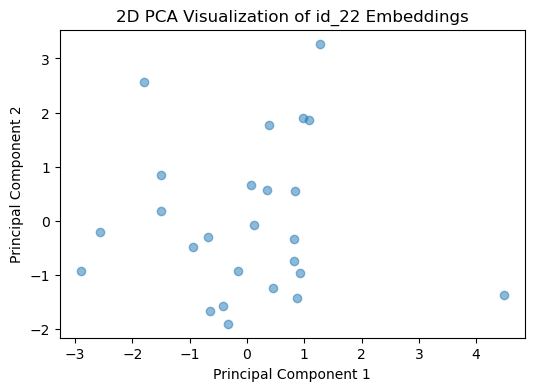

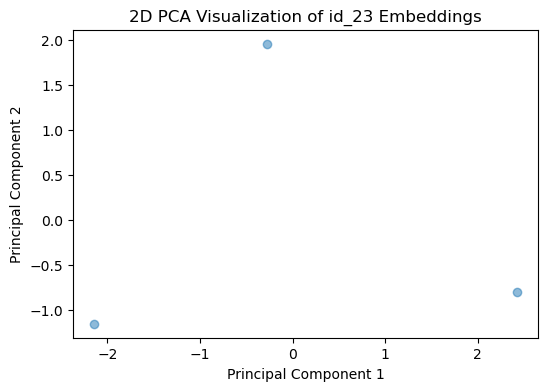

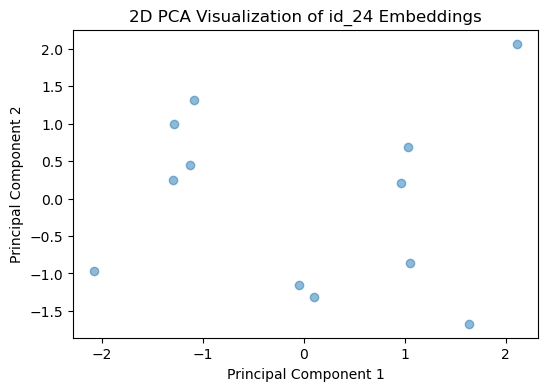

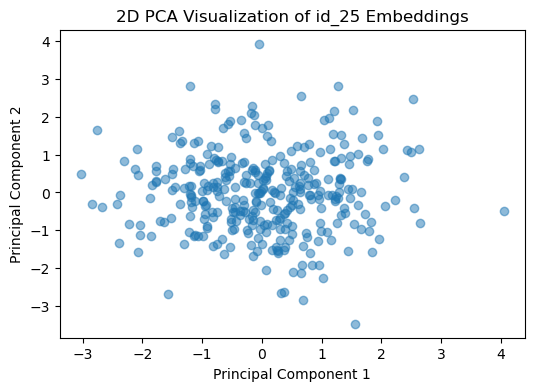

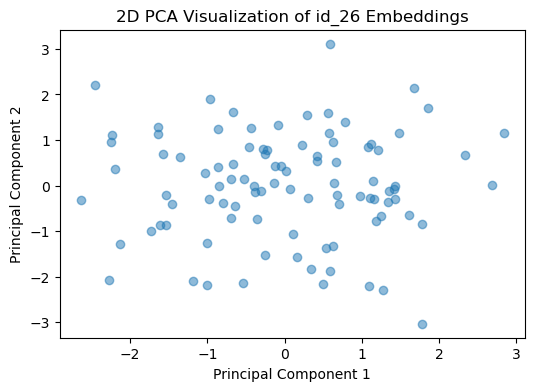

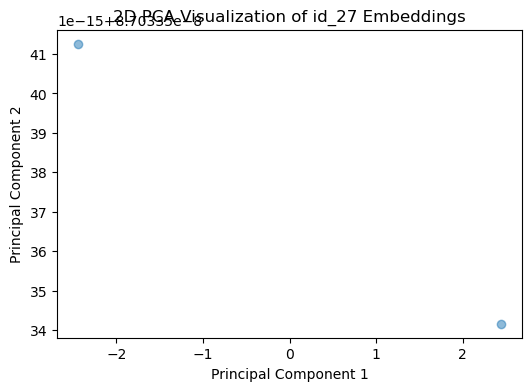

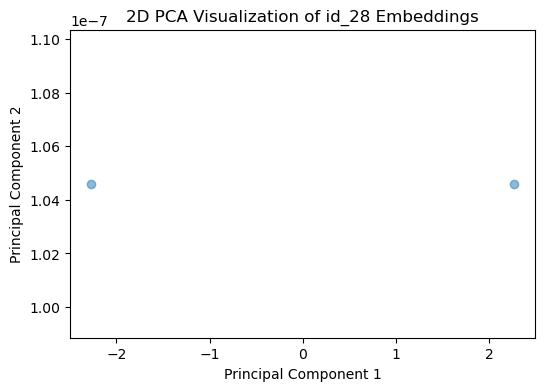

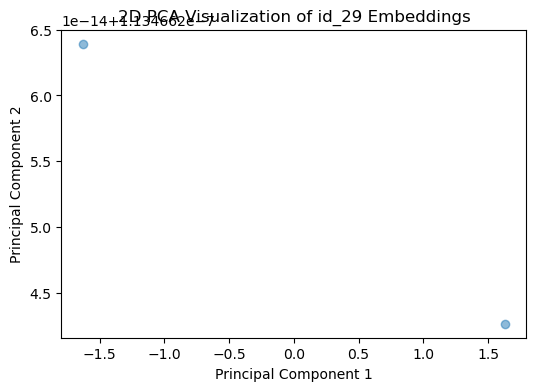

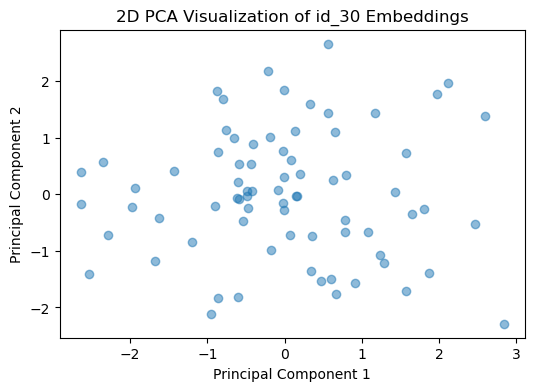

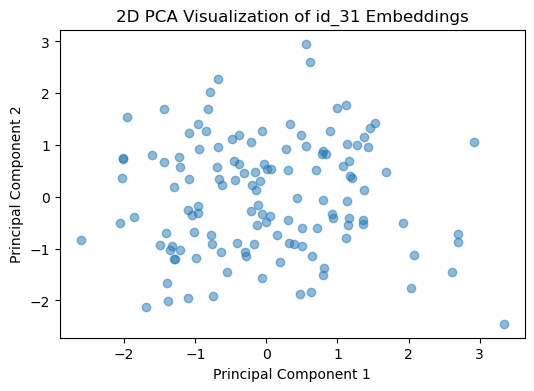

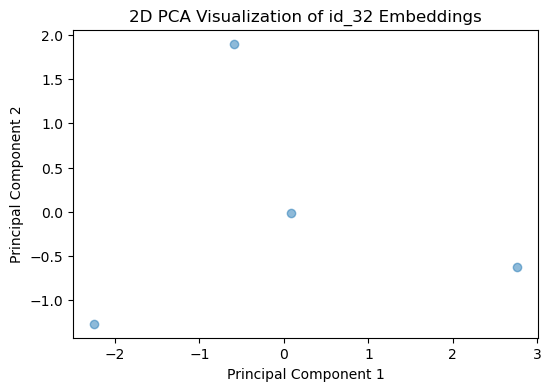

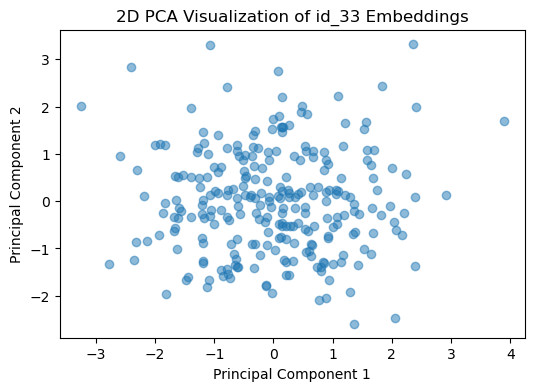

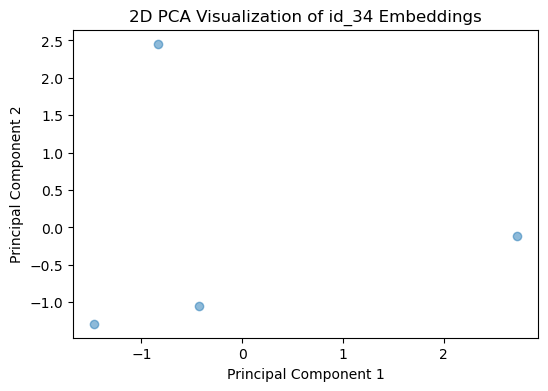

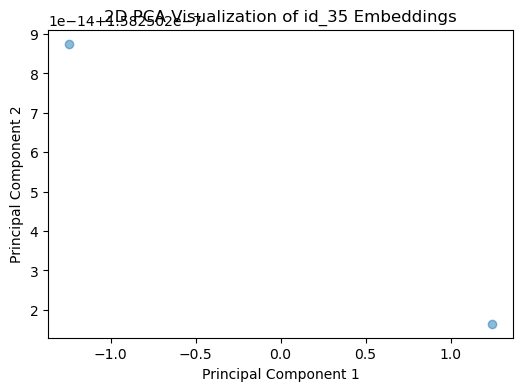

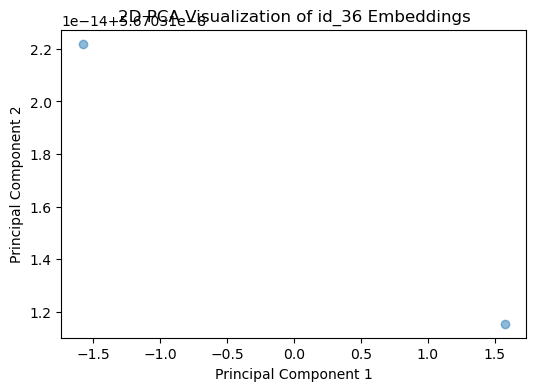

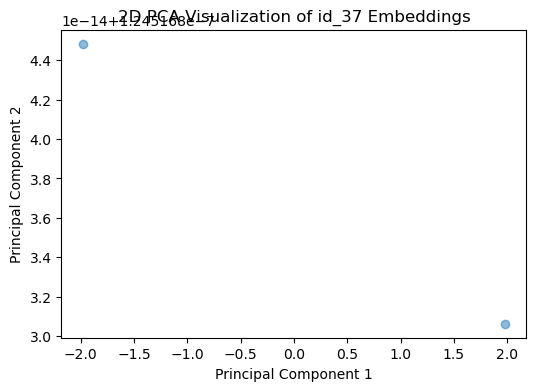

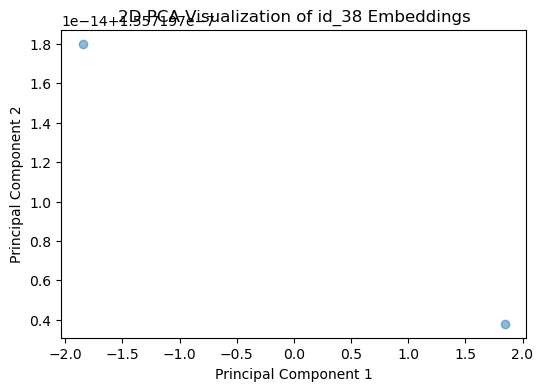

In [64]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_all_embeddings(embedding_layer):
    for entity_name in embedding_layer.embeds:
        # Extract the embeddings for the current entity
        entity_embeddings = embedding_layer.embeds[entity_name].weight.cpu().detach().numpy()
        
        # Use PCA to reduce the dimensions to 2D
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(entity_embeddings)
        
        # Plot the 2D embeddings
        plt.figure(figsize=(10, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
        plt.title(f'2D PCA Visualization of {entity_name} Embeddings')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

# Usage:
visualize_all_embeddings(model.embed_layer)


### 3. Training and evaluation 
### 4. Experimentation

### Architecture 2

Epoch 10 loss: 0.970, (rate of change: -0.0109), val accuracy: 0.869 (best: 0.899)
            -- Average time per epoch: 9.6sec (last 5: 9.1sec).            Estimated time to end: 3 mins
Epoch 20 loss: 0.899, (rate of change: -0.0023), val accuracy: 0.858 (best: 0.899)
            -- Average time per epoch: 9.6sec (last 5: 9.7sec).            Estimated time to end: 2 mins


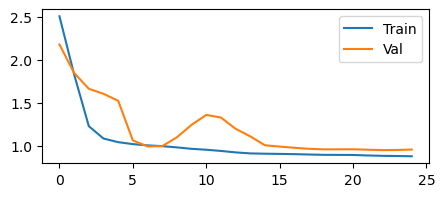

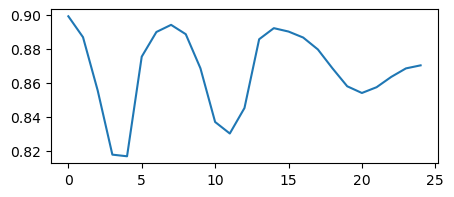

Epoch 30 loss: 0.873, (rate of change: -0.0013), val accuracy: 0.855 (best: 0.899)
            -- Average time per epoch: 9.6sec (last 5: 9.7sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 0.873,     final val accuracy: 0.855, (best: 0.899).
Training set: mean of probabilities, predictions, and true labels:
tensor(0.3253, grad_fn=<MeanBackward0>)
tensor(0.1386)
tensor(0.0351)

Validation set:
tensor(0.3325, grad_fn=<MeanBackward0>)
tensor(0.1429)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 14.29 %.
[[99062  2169]
 [14982  1895]]
False positive rate: 88.8 %.
False negative rate: 2.14 %.
True negative rate: 11.23 % (specificity).
True positive rate: 97.86 % (sensitivity).


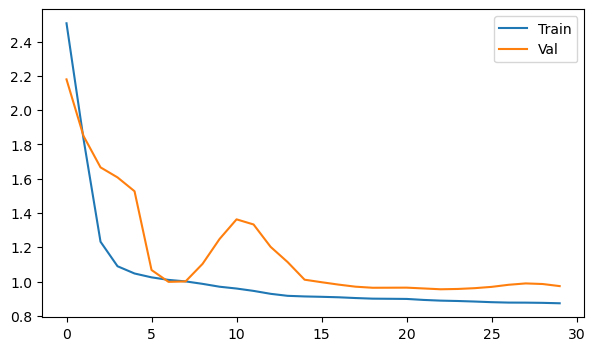

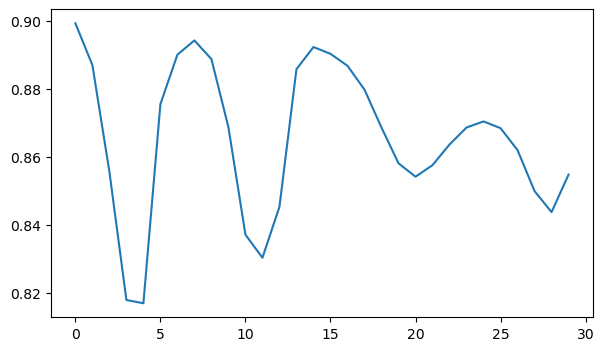

In [40]:
# Convolution layers
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8
#should be at least 2; only have 3 'distinct' layers, 
#weights for the middle ones are shared with all layers except first and last.
CONV_LAYERS = 2 
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

from dgl.nn.pytorch import HeteroGraphConv, HeteroEmbedding, GraphConv
from torch.nn import Linear

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

#Defining the Feed Forward Neural net  for preprocessing and postprocessing the target label
class feedfwd_block(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers):
        super().__init__()
        self.input_layer = Linear(in_dim, hidden_dim)
        self.hidden_layer = Linear(hidden_dim, hidden_dim)
        self.output_layer = Linear(hidden_dim, out_dim)
        self.n_layers = n_layers
        
##Activation function : ReLU 
    def forward(self, in_feats):
        h = self.input_layer(in_feats)
        h = nn.ReLU()(h)
        for i in range(1, self.n_layers):
            h = self.hidden_layer(h)
            h = nn.ReLU()(h)
        h = self.output_layer(h)        
        return h
            

#Defining the Model class
class RGCN(nn.Module):
    def __init__(self, target_feature_dim, in_dim, hidden_dim, conv_out_dim, num_conv_layers, num_embeddings, target_pre_h_dim, target_pre_layers, target_post_h_dim, target_post_layers):
        super().__init__()
        #Creating dictionary for HeteroGraphConv
        entry_module_dict = { etype : GraphConv(in_feats=in_dim, out_feats=hidden_dim) for etype in g.etypes}

        hidden_model_dict = { etype : GraphConv(in_feats=hidden_dim, out_feats=hidden_dim) for etype in g.etypes}

        final_model_dict1 = { etype : GraphConv(in_feats=hidden_dim, out_feats=conv_out_dim) for src,etype,dst in g.canonical_etypes if dst == 'target'}
        final_model_dict2 = { etype : GraphConv(in_feats=hidden_dim, out_feats=1) for src,etype,dst in g.canonical_etypes if dst != 'target'}
        final_model_dict = {**final_model_dict1, **final_model_dict2}
        
        self.num_conv_layers = num_conv_layers
        
        self.embed_layer = HeteroEmbedding(
            num_embeddings,
            in_dim
        )
        ##Preprocessing block for target features--layers for message passing and aggregation over the graph.
        self.target_preprocessing = feedfwd_block(
            target_feature_dim, 
            target_pre_h_dim, 
            in_dim, 
            target_pre_layers)
        self.conv1 = HeteroGraphConv(
            entry_module_dict,
            aggregate = 'sum'
        )
        self.conv2 = HeteroGraphConv(
                hidden_model_dict,
                aggregate = 'sum'
        )

        self.conv3 = HeteroGraphConv(
            final_model_dict,
            aggregate = 'sum'
        )
        self.target_postprocessing = feedfwd_block(
            conv_out_dim, 
            target_post_h_dim, 
            1, 
            target_post_layers
        )
#defining the forward pass of the model, 
#incorporating the embedding, preprocessing, convolutional layers, and postprocessing        
    def forward(self, graph, input_features):
        embeds = self.embed_layer({ ntype : graph.nodes(ntype) for ntype in node_types }) #Embedding 
        input_features = input_features.to(dtype=torch.float32) #Input
        target_features = self.target_preprocessing(input_features) #Target
        embeds['target'] = target_features 
        h = self.conv1(graph, embeds)
        h = {k: F.relu(v) for k, v in h.items()}
        for i in range(2, self.num_conv_layers):
            h = self.conv2(graph, h)
            h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv3(graph, h)
        h['target'] = self.target_postprocessing(h['target'])
        
        return h

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

#Function will take care of one training epoch for the model
def train_one_epoch(epoch_no, model, g, features, labels, train_mask, val_mask, threshold, return_probs=False):
    t0 = time()
    # Forward pass - Logits are converted to probabilities using a sigmoid activation function
    logits_dict = model(g, features)
    logits = logits_dict['target']
    del logits_dict
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
       
    labels = labels.reshape_as(preds)
    
    #Calculating the training and validation losses
    loss = loss_fn(probs[train_mask], labels[train_mask])
    with torch.no_grad():
        val_loss = val_loss_fn(probs[val_mask], labels[val_mask])
    
    #Calculating the accuracies
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    
    #backprop after each epoch optimizer's gradient is zeroed.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#Return the following values post the epoch    
    if return_probs:
        return loss, val_loss, train_acc, val_acc, time()-t0, probs, preds
    else:
        return loss, val_loss, train_acc, val_acc, time()-t0


#visualise loss history
def loss_history_plot(loss_history, val_loss_history=None, small=False):
    if small:
        size = (5,2)
    else:
        size = (7,4)
    fig, ax =plt.subplots(1,1,figsize=size)
    ax.plot(loss_history, label='Train')
    if val_loss_history:
        ax.plot(val_loss_history, label='Val')
        ax.legend()
    plt.show()

#Final model
def train(model, g, num_epochs, labels, train_mask, val_mask, threshold):
    best_val_acc = 0
    epoch_times = []
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    
    features = g.nodes['target'].data['features']
    
    for epoch in range(num_epochs):
        
        if epoch < num_epochs-1:
            loss, val_loss, train_acc, val_acc, epoch_time = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold)
        else:
            loss, val_loss, train_acc, val_acc, epoch_time, final_probs, final_preds = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold, return_probs=True)
            
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['loss'].append(loss.detach().numpy())
        epoch_times.append(epoch_time)
        
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            
        if epoch % 10 == 10-1:
            loss_rate_of_change = (history['loss'][-1]-history['loss'][-5])/5
            print(f"Epoch {epoch+1} loss: {loss:.3f}, (rate of change: {loss_rate_of_change:.4f}), val accuracy: {val_acc:.3f} (best: {best_val_acc:.3f})\n\
            -- Average time per epoch: {np.mean(epoch_times):.1f}sec (last 5: {np.mean(epoch_times[-5:]):.1f}sec).\
            Estimated time to end: {(num_epochs-epoch-1)*np.mean(epoch_times[-5:])/60:.0f} mins")
            
        if epoch % 25 == 25-1:
            loss_history_plot(history['loss'][-25:], history['val_loss'][-25:], small=True)
            loss_history_plot(history['val_acc'][-25:], small=True)
            
    print('-'*60)
    print(f"Training complete. \
    Final loss: {loss:.3f}, \
    final val accuracy: {val_acc:.3f}, (best: {best_val_acc:.3f}).")
    
    return final_probs, final_preds, history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


Epoch 10 loss: 1.008, (rate of change: 0.0005), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 8.5sec (last 5: 8.5sec).            Estimated time to end: 3 mins
Epoch 20 loss: 1.005, (rate of change: -0.0002), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 8.9sec (last 5: 9.3sec).            Estimated time to end: 2 mins


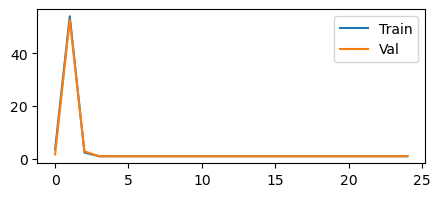

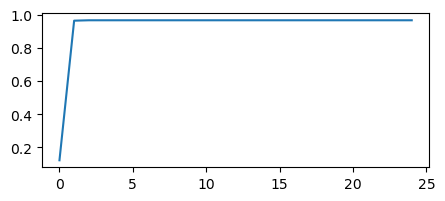

Epoch 30 loss: 1.005, (rate of change: -0.0001), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 9.1sec (last 5: 9.4sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 1.005,     final val accuracy: 0.966, (best: 0.966).
Training set: mean of probabilities, predictions, and true labels:
tensor(0.3774, grad_fn=<MeanBackward0>)
tensor(0.)
tensor(0.0351)

Validation set:
tensor(0.3774, grad_fn=<MeanBackward0>)
tensor(0.)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 0.00 %.
[[114044   4064]
 [     0      0]]
False positive rate: nan %.
False negative rate: 3.44 %.
True negative rate: nan % (specificity).
True positive rate: 96.56 % (sensitivity).


C:\Users\Deepti Gupta\AppData\Local\Temp\ipykernel_1852\628131714.py:77: RuntimeWarning: invalid value encountered in scalar divide
  fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])


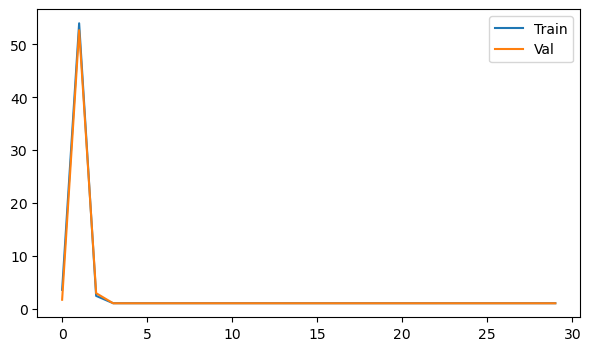

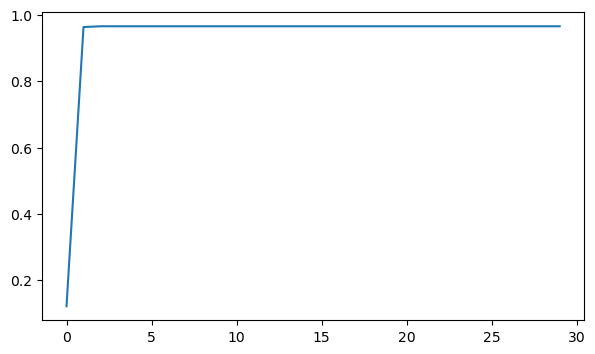

In [47]:
# Convolution layers
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8

CONV_LAYERS = 2
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.1
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function	
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

#Function will take care of one training epoch for the model
                                                                                                                                                                  
#visualise loss history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### Architecture 3

Epoch 10 loss: 1.031, (rate of change: -0.0060), val accuracy: 0.925 (best: 0.948)
            -- Average time per epoch: 9.4sec (last 5: 9.4sec).            Estimated time to end: 3 mins
Epoch 20 loss: 1.026, (rate of change: -0.0003), val accuracy: 0.926 (best: 0.948)
            -- Average time per epoch: 9.4sec (last 5: 9.5sec).            Estimated time to end: 2 mins


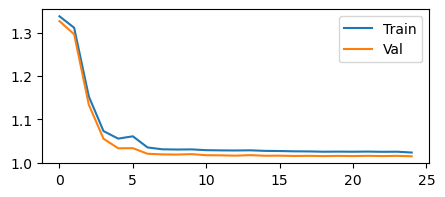

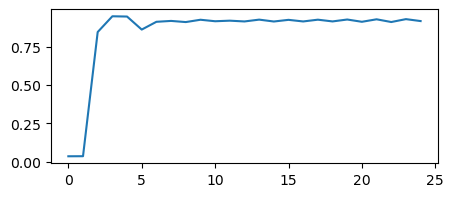

Epoch 30 loss: 1.022, (rate of change: -0.0002), val accuracy: 0.919 (best: 0.948)
            -- Average time per epoch: 9.4sec (last 5: 9.5sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 1.022,     final val accuracy: 0.919, (best: 0.948).
Training set: mean of probabilities, predictions, and true labels:
tensor(0.0707, grad_fn=<MeanBackward0>)
tensor(0.0691)
tensor(0.0351)

Validation set:
tensor(0.0725, grad_fn=<MeanBackward0>)
tensor(0.0704)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 7.04 %.
[[107128   2662]
 [  6916   1402]]
False positive rate: 83.1 %.
False negative rate: 2.42 %.
True negative rate: 16.86 % (specificity).
True positive rate: 97.58 % (sensitivity).


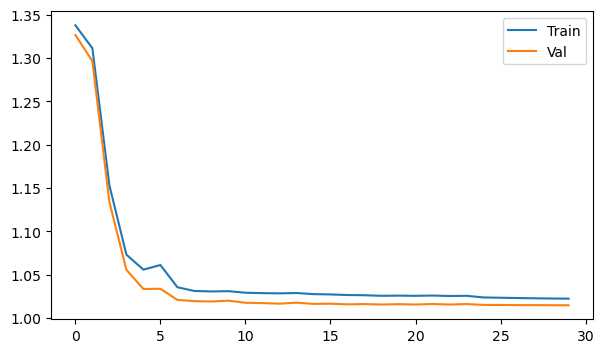

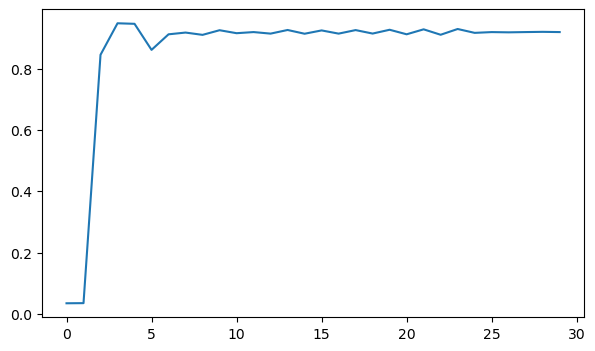

In [48]:
# Convolution layers
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8
#should be at least 2; only have 3 'distinct' layers, 
#weights for the middle ones are shared with all layers except first and last.
CONV_LAYERS = 2
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCEWithLogitsLoss(weight_vector)
val_loss_fn = torch.nn.BCEWithLogitsLoss(val_weight_vector)
#Function will take care of one training epoch for the model
                                                                                                                                                                  
#visualise loss history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### Architecture 4

Epoch 10 loss: 1.031, (rate of change: -0.0281), val accuracy: 0.705 (best: 0.705)
            -- Average time per epoch: 11.0sec (last 5: 10.9sec).            Estimated time to end: 4 mins
Epoch 20 loss: 0.964, (rate of change: -0.0040), val accuracy: 0.818 (best: 0.818)
            -- Average time per epoch: 11.0sec (last 5: 11.0sec).            Estimated time to end: 2 mins


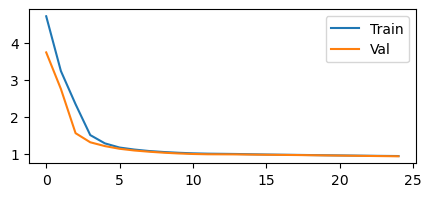

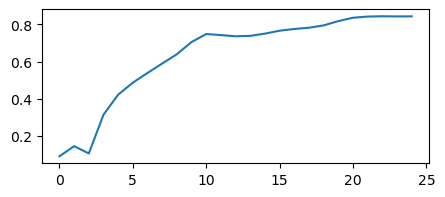

Epoch 30 loss: 0.922, (rate of change: -0.0034), val accuracy: 0.856 (best: 0.856)
            -- Average time per epoch: 11.0sec (last 5: 10.9sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 0.922,     final val accuracy: 0.856, (best: 0.856).
Training set: mean of probabilities, predictions, and true labels:
tensor(0.4049, grad_fn=<MeanBackward0>)
tensor(0.1493)
tensor(0.0351)

Validation set:
tensor(0.4125, grad_fn=<MeanBackward0>)
tensor(0.1429)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 14.29 %.
[[99108  2126]
 [14936  1938]]
False positive rate: 88.5 %.
False negative rate: 2.10 %.
True negative rate: 11.49 % (specificity).
True positive rate: 97.90 % (sensitivity).


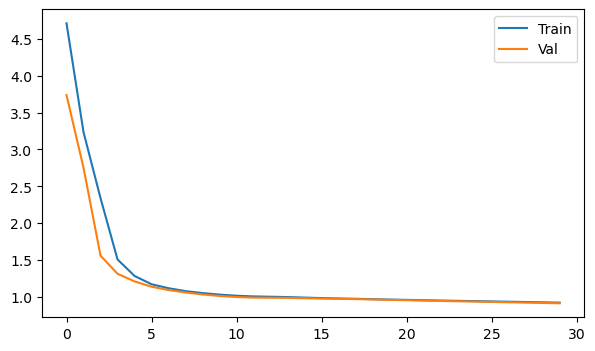

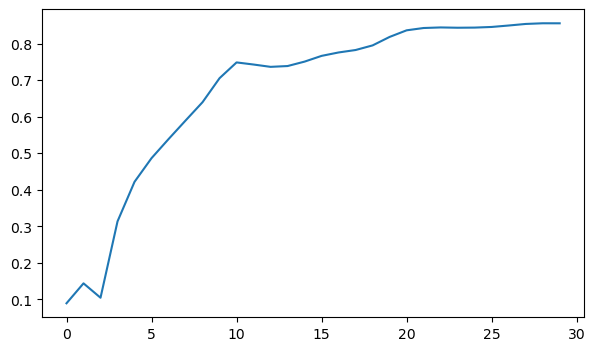

In [49]:
# Convolution layers
INPUT_DIM = 16
HIDDEN_DIM = 16
TARGET_OUT_DIM = 8

CONV_LAYERS = 2
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 4
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function	
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

#Function will take care of one training epoch for the model
                                                                                                                                                                  
#visualise loss history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### Architecture 5

Epoch 10 loss: 1.058, (rate of change: 0.0000), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 10.9sec (last 5: 10.9sec).            Estimated time to end: 4 mins
Epoch 20 loss: 1.058, (rate of change: 0.0000), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 10.8sec (last 5: 10.7sec).            Estimated time to end: 2 mins


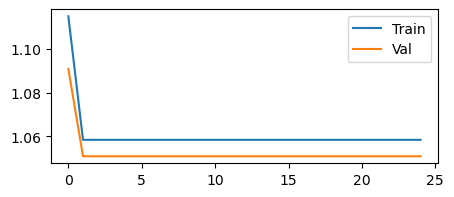

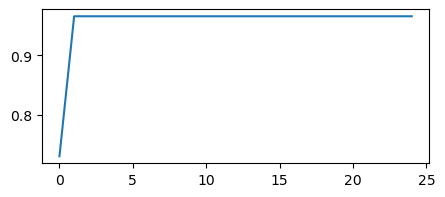

Epoch 30 loss: 1.058, (rate of change: 0.0000), val accuracy: 0.966 (best: 0.966)
            -- Average time per epoch: 10.8sec (last 5: 10.7sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 1.058,     final val accuracy: 0.966, (best: 0.966).
Training set: mean of probabilities, predictions, and true labels:
tensor(0., grad_fn=<MeanBackward0>)
tensor(0.)
tensor(0.0351)

Validation set:
tensor(0., grad_fn=<MeanBackward0>)
tensor(0.)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 0.00 %.
[[114044   4064]
 [     0      0]]
False positive rate: nan %.
False negative rate: 3.44 %.
True negative rate: nan % (specificity).
True positive rate: 96.56 % (sensitivity).


C:\Users\Deepti Gupta\AppData\Local\Temp\ipykernel_1852\3392899037.py:77: RuntimeWarning: invalid value encountered in scalar divide
  fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])


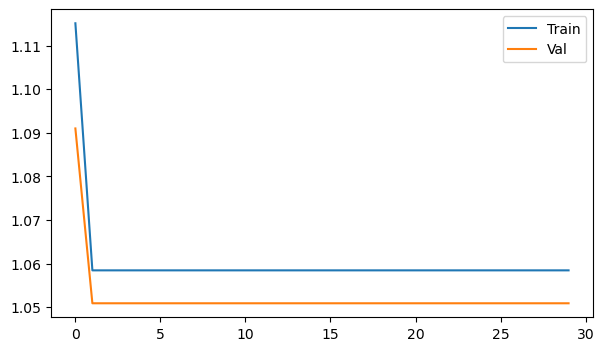

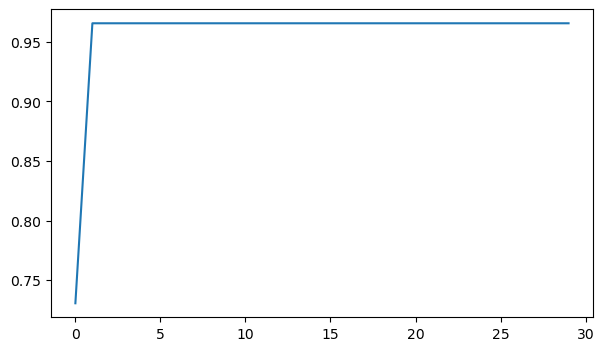

In [50]:
# Convolution layers
INPUT_DIM = 16
HIDDEN_DIM = 16
TARGET_OUT_DIM = 8

CONV_LAYERS = 2
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 4
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.1
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCEWithLogitsLoss(weight_vector)
val_loss_fn = torch.nn.BCEWithLogitsLoss(val_weight_vector)

#Function will take care of one training epoch for the model
                                                                                                                                                                  
#visualise loss history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### Architecture 6

Epoch 10 loss: 1.045, (rate of change: -0.0049), val accuracy: 0.948 (best: 0.964)
            -- Average time per epoch: 69.5sec (last 5: 71.9sec).            Estimated time to end: 24 mins
Epoch 20 loss: 1.032, (rate of change: -0.0020), val accuracy: 0.901 (best: 0.964)
            -- Average time per epoch: 70.9sec (last 5: 76.0sec).            Estimated time to end: 13 mins


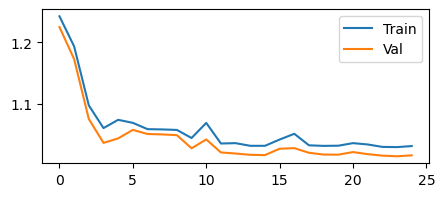

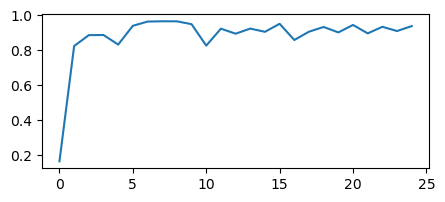

Epoch 30 loss: 1.028, (rate of change: -0.0005), val accuracy: 0.916 (best: 0.964)
            -- Average time per epoch: 73.2sec (last 5: 80.0sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 1.028,     final val accuracy: 0.916, (best: 0.964).
Training set: mean of probabilities, predictions, and true labels:
tensor(0.0712, grad_fn=<MeanBackward0>)
tensor(0.0708)
tensor(0.0351)

Validation set:
tensor(0.0745, grad_fn=<MeanBackward0>)
tensor(0.0742)
tensor(0.0344)
Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 7.42 %.
[[106748   2598]
 [  7296   1466]]
False positive rate: 83.3 %.
False negative rate: 2.38 %.
True negative rate: 16.73 % (specificity).
True positive rate: 97.62 % (sensitivity).


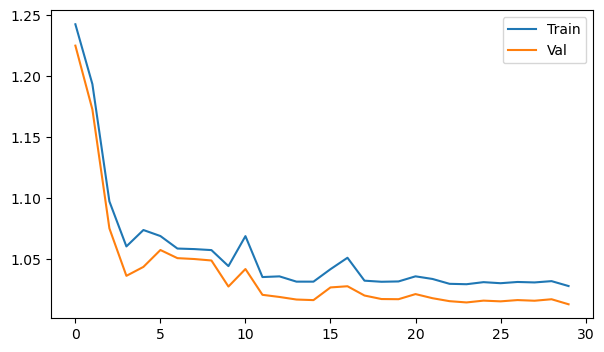

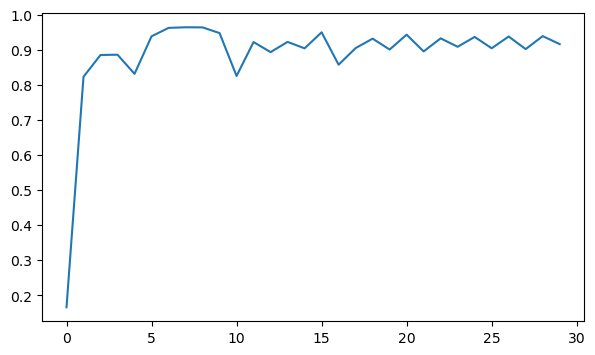

In [51]:
# Convolution layers
INPUT_DIM = 32
HIDDEN_DIM = 32
TARGET_OUT_DIM = 8

CONV_LAYERS = 4
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 4
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.1
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 30

# getting dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# Creating linear numeric embeddings for the non-target nodes
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# Creating the model RGCN
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)

#Weight vector for loss multiplier will help dealing with the class imbalance in bot train and validate
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

#Optimizer minimizing the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Loss function as Binary Cross Entropy as this is a two class problem
loss_fn = torch.nn.BCEWithLogitsLoss(weight_vector)
val_loss_fn = torch.nn.BCEWithLogitsLoss(val_weight_vector)

#Function will take care of one training epoch for the model
                                                                                                                                                                  
#visualise loss history

QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())

print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())

print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])


### 6. Summary
-- In the report